In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard Library Imports
import datetime
import json
import os
import sys
import time
from itertools import product

import colorcet as cc
import matplotlib.pyplot as plt
import networkx as nx

# Third-Party Library Imports
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.sparse as sparse
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv("PYTHONPATH")
data_dir = os.getenv("DATA_DIR")
src_dir = os.getenv("SRC_DIR")
output_dir = os.getenv("OUTPUT_DIR")

from src.main_path.MainPathDataAssigner import MainPathDataAssigner
from src.main_path.MainPathReader import MainPathReader
from src.main_path.MainPathPlotterInteractive import MainPathPlotterInteractive
from src.main_path.MainPathPlotterStatic import MainPathPlotterStatic

In [3]:
p = data_dir + "/08-analysis-data/2025/df_analysis.pkl"
df = pd.read_pickle(p)

p_labels = (
    output_dir
    + "/cluster-qualifications_2025/cluster-label-tree/cluster_labels_filtered.json"
)
cluster_labels_dict = json.load(open(p_labels, "r"))

p_color = output_dir + "/cluster-qualifications_2025/colors/cluster_color_map_2025.json"
cluster_color_dict = json.load(open(p_color, "r"))

Cannot be read by networkx, so reading in from scratch

# read in main path data from pajek


In [4]:
path_to_main_path = (
    data_dir
    + "/10-main-path-graphs/2025/nice covid one25. Key-Route Global Main Path [75-125] of N2 (155).net"
)

mp_reader = MainPathReader(path_to_main_path, node_attributes=["eid"])
Gmp = mp_reader.get_graph()

DiGraph with 155 nodes and 188 edges


In [5]:
list(Gmp.nodes(data=True))[0]

('1',
 {'label': 'family_Boeck_1982_Pedersen_1982',
  'x': '0.2730',
  'y': '0.0553',
  'size': '0.5000',
  'shape': 'ellipse',
  'eid': '2-s2.0-0019989539;2-s2.0-0020047901'})

# Add Info from df to mp


In [8]:
attr_to_assign = [
    "title",
    "citedby_count",
    "doi",
    "year",
    "cluster_alpha0.3_k10_res0.002",
    # "centrality_alpha0.3_k10_res0.002",
    "authors_apa_string",
]
data_assigner = MainPathDataAssigner(
    Gmp, df, attr_to_assign, cluster_labels_dict, cluster_color_dict
)
Gmp = data_assigner.process_mp()
print("family node:")
print(list(Gmp.nodes(data=True))[9])
print("single node:")
print(list(Gmp.nodes(data=True))[0])

family node:
('10', {'label': 'Overmars_1983', 'eid': '2-s2.0-0021077683', 'title': 'Fluvoxamine maleate: metabolism in man', 'citedby_count': '65', 'doi': '10.1007/BF03188757', 'year': '1983', 'cluster_alpha0.3_k10_res0.002': '6', 'authors_apa_string': 'Overmars et al.', 'cluster_label': 'SSRIs and the Cytochrome P450 System', 'color': [0.1270824126203872, 0.32798911987262874, 0.8204457680820253]})
single node:
('1', {'label': 'family_Boeck_1982_Pedersen_1982', 'eid': '2-s2.0-0019989539;2-s2.0-0020047901', 'title': 'Citalopram, a selective serotonin reuptake inhibitor: Clinical antidepressive and long-term effect - a phase II study;Studies on Acute Toxicity and Drug Levels of Citalopram in the Dog', 'citedby_count': '62;34', 'doi': '10.1007/BF00464566;10.1111/j.1600-0773.1982.tb00959.x', 'year': '1982;1982', 'cluster_alpha0.3_k10_res0.002': '19;48', 'authors_apa_string': 'Pedersen et al.;Boeck et al.', 'cluster_label': 'Escitalopram for Depression;QTC Prolongation', 'color': [0.419039

# plot


In [31]:
plotter = MainPathPlotterInteractive(
    Gmp,
    cluster_col="cluster_alpha0.3_k10_res0.002",
    node_label_col="label",
    hover_cols=["title", "cited_by", "year", "first_author"],
    color_attr="color",
    cluster_label_attr="cluster_label",
)
# Show network visualization
fig_interactive = plotter.plot_network_on_timeline_interactive(
    savingpath=output_dir + "/figures/main-paths/2025/timeline_visualization.html",
    width=1100,
    height=1500,
    return_fig=True,
    adjust_overlap=True,
    show_legend=True,
    title="",
    use_custom_colors=True,
    show_labels=False,
)
# Show timeline view
# plotter.plot_timeline_view()
# Save visualizations
# plotter.plot_network_on_timeline_interactive(savingpath="network_visualization.html")#
# plotter.plot_timeline_view(savingpath="timeline_visualization.html")

# For paper


In [140]:
import colorcet as cc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex


class MainPathPlotterStatic:
    """
    A modified version of MainPathPlotterInteractive that creates static figures
    with better node separation and density control.
    """

    def __init__(
        self,
        G,
        cluster_col="cluster_0",
        label_col="label",
        hover_cols=["title", "cited_by", "year", "first_author"],
        color_attr="color",
        cluster_label_attr="cluster_label",
    ):
        """Initialize with the same parameters as the original class."""
        self.G = G
        self.cluster_col = cluster_col
        self.label_col = label_col
        self.color_attr = color_attr
        self.cluster_label_attr = cluster_label_attr

        # Add cluster information to hover if they exist in the graph
        additional_cols = []
        if cluster_label_attr in next(iter(G.nodes(data=True)))[1]:
            additional_cols.append(cluster_label_attr)
        if "doi" in next(iter(G.nodes(data=True)))[1]:
            additional_cols.append("doi")

        self.hover_cols = hover_cols + additional_cols

        # Don't add these twice if they're already included
        if label_col not in self.hover_cols:
            self.hover_cols.append(label_col)
        if cluster_col not in self.hover_cols:
            self.hover_cols.append(cluster_col)

        self.pos = None

    def adjust_overlap(self, min_dist=0.3, max_iterations=150):
        """
        Adjusts the positions to reduce overlap with increased minimum distance.

        Args:
            min_dist (float): Minimum desired distance between nodes.
            max_iterations (int): Maximum number of iterations to perform adjustments.

        Returns:
            dict: Adjusted positions.
        """
        for iteration in range(max_iterations):
            moved = False
            for node1 in self.pos:
                for node2 in self.pos:
                    if node1 != node2:
                        # Calculate the distance between two nodes
                        delta = np.array(self.pos[node1]) - np.array(self.pos[node2])
                        dist = np.sqrt(np.sum(delta**2))
                        # If the nodes are too close, push them apart
                        if dist < min_dist:
                            moved = True
                            # Increase the repulsion factor for more separation
                            repulsion_factor = 0.6  # Increased from 0.5
                            displacement = (
                                delta / dist * (min_dist - dist) * repulsion_factor
                            )
                            self.pos[node1] = self.pos[node1] + displacement
                            self.pos[node2] = self.pos[node2] - displacement
            # If no nodes were moved in this iteration, stop the adjustment
            if not moved:
                print(f"Adjustment finished after {iteration} iterations")
                break

        # Scale positions to fit well within the plot
        positions = np.array(list(self.pos.values()))
        x_min, y_min = positions.min(axis=0)
        x_max, y_max = positions.max(axis=0)

        # Normalize to fit within a reasonable range with a tighter scaling
        scale_factor = 0.9  # Reduced from 1.0 to make layout more dense
        for node in self.pos:
            self.pos[node] = (
                scale_factor
                * (self.pos[node] - np.array([x_min, y_min]))
                / np.array([x_max - x_min, y_max - y_min])
            )

        return self.pos

    def get_node_colors(self):
        """
        Get node colors from the color attribute if available, otherwise generate colors based on clusters.

        Returns:
            list: List of colors for each node.
        """
        # Check if color attribute exists from MainPathDataAssigner
        if self.color_attr in next(iter(self.G.nodes(data=True)))[1]:
            # Use the RGB values assigned by MainPathDataAssigner
            colors = []
            for _, data in self.G.nodes(data=True):
                rgb_values = data.get(self.color_attr)
                if isinstance(rgb_values, list) and len(rgb_values) == 3:
                    # Convert RGB values (0-1 scale) to hex color for matplotlib
                    r, g, b = rgb_values
                    color_hex = rgb2hex((r, g, b))
                    colors.append(color_hex)
                else:
                    # Default color if RGB values are not available
                    colors.append("#808080")  # Gray
            return colors
        else:
            # Generate colors based on clusters
            return self._generate_cluster_colors()

    def _generate_cluster_colors(self):
        """
        Generate colors based on cluster values.

        Returns:
            list: List of colors for each node.
        """
        clusters = [
            data.get(self.cluster_col, "0") for _, data in self.G.nodes(data=True)
        ]

        # Handle multi-cluster nodes (take the first cluster)
        processed_clusters = []
        for cluster in clusters:
            if isinstance(cluster, str) and ";" in cluster:
                processed_clusters.append(cluster.split(";")[0])
            else:
                processed_clusters.append(str(cluster))

        unique_clusters = sorted(set(processed_clusters))

        # Using colorcet to get a colormap with enough distinct colors
        color_list = cc.glasbey_dark[: len(unique_clusters)]

        # Creating a color dictionary mapping each cluster to a color
        color_dict = {
            cluster: color_list[i] for i, cluster in enumerate(unique_clusters)
        }

        # Generate colors for each node
        return [color_dict[cluster] for cluster in processed_clusters]

    def plot_static_network(
        self,
        savingpath=None,
        layout_scale=3.0,  # Reduced from 5.0 to make layout more dense
        min_dist=0.3,  # Increased from 0.15 for better separation
        node_size_base=80,  # Base node size for better visibility
        node_size_factor=5,  # Factor to multiply degree by
        figsize=(16, 12),  # Larger figure size
        dpi=150,  # Higher DPI for better quality
        label_fontsize=7,  # Smaller font for labels
        edge_width=0.8,  # Slightly thicker edges
        alpha=0.8,  # Node transparency
        title=None,
        with_labels=True,
        adjust_overlap=True,
        pos=None,
        use_spring_layout=False,  # Option to use spring layout instead of kamada_kawai
        show_legend=True,  # Whether to show the cluster legend
        legend_fontsize=8,  # Font size for legend
        legend_title="Clusters",  # Title for the legend
    ):
        """
        Create a static network visualization using matplotlib.

        Args:
            savingpath (str, optional): Path to save the visualization.
            layout_scale (float): Scale parameter for the layout algorithm.
            min_dist (float): Minimum distance between nodes.
            node_size_base (int): Base size for nodes.
            node_size_factor (int): Factor to multiply node degree by for sizing.
            figsize (tuple): Figure dimensions (width, height).
            dpi (int): Dots per inch for the output figure.
            label_fontsize (int): Font size for node labels.
            edge_width (float): Width of edges.
            alpha (float): Transparency of nodes.
            title (str, optional): Plot title.
            with_labels (bool): Whether to show node labels.
            adjust_overlap (bool): Whether to adjust node positions to reduce overlap.
            pos (dict, optional): Pre-calculated node positions.
            use_spring_layout (bool): Use spring layout instead of kamada_kawai.
            show_legend (bool): Whether to show the cluster legend.
            legend_fontsize (int): Font size for the legend.
            legend_title (str): Title for the legend.

        Returns:
            matplotlib.figure.Figure: The figure object.
        """
        # Set up the figure and axes with space for legend
        if show_legend:
            # Create figure with additional space on the right for legend
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
            plt.subplots_adjust(
                right=0.8
            )  # Adjust the right boundary to make room for legend
        else:
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        # Set node positions
        if not pos:
            if use_spring_layout:
                # Spring layout can produce more compact layouts
                self.pos = nx.spring_layout(
                    self.G,
                    k=layout_scale / np.sqrt(len(self.G)),  # Optimal distance
                    iterations=150,  # More iterations for better convergence
                    seed=42,  # For reproducibility
                )
            else:
                # Default to kamada_kawai for better distributed layouts
                self.pos = nx.kamada_kawai_layout(
                    self.G,
                    weight=None,
                    scale=layout_scale,
                    center=None,
                    dim=2,
                )
        else:
            self.pos = pos

        # Adjust node positions to reduce overlap if requested
        if adjust_overlap:
            self.pos = self.adjust_overlap(min_dist, 150)

        # Get node colors
        node_colors = self.get_node_colors()

        # Calculate node sizes based on node degree
        degrees = dict(self.G.degree())
        node_sizes = [
            node_size_base + (degrees[node] * node_size_factor)
            for node in self.G.nodes()
        ]

        # Get node labels if needed
        if with_labels:
            node_labels = {
                node: data.get(self.label_col, "")
                for node, data in self.G.nodes(data=True)
            }
        else:
            node_labels = {}

        # Draw the network
        # Draw edges first so they appear under nodes
        nx.draw_networkx_edges(
            self.G, self.pos, ax=ax, width=edge_width, alpha=0.6, edge_color="gray"
        )

        # Draw nodes
        nx.draw_networkx_nodes(
            self.G,
            pos=self.pos,
            ax=ax,
            node_size=node_sizes,
            node_color=node_colors,
            alpha=alpha,
            edgecolors="black",
            linewidths=0.5,
        )

        # Draw labels if requested
        if with_labels:
            nx.draw_networkx_labels(
                self.G,
                self.pos,
                ax=ax,
                labels=node_labels,
                font_size=label_fontsize,
                font_weight="normal",
                font_color="black",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5),
            )

        # Add title if provided
        if title:
            ax.set_title(title, fontsize=14, fontweight="bold")

        # Remove axes
        ax.axis("off")

        # Add legend if requested
        if (
            show_legend
            and self.cluster_label_attr in next(iter(self.G.nodes(data=True)))[1]
        ):
            self._add_legend_to_plot(ax, legend_fontsize, legend_title)

        # Adjust layout
        plt.tight_layout()

        # Save the figure if savingpath is provided
        if savingpath:
            plt.savefig(savingpath, dpi=dpi, bbox_inches="tight")
            print(f"Figure saved to {savingpath}")

        # Show the figure
        plt.show()

        # Return the figure object
        return fig

    def _add_legend_to_plot(self, ax, fontsize=8, title="Clusters"):
        """
        Add a legend to the plot.

        Args:
            ax (matplotlib.axes.Axes): Axes to add legend to.
            fontsize (int): Font size for legend.
            title (str): Legend title.

        Returns:
            matplotlib.legend.Legend: The legend object.
        """
        # Get cluster labels and colors
        cluster_data = {}
        for _, data in self.G.nodes(data=True):
            cluster_id = data.get(self.cluster_col, "0")
            if isinstance(cluster_id, str) and ";" in cluster_id:
                cluster_id = cluster_id.split(";")[0]

            cluster_label = data.get(self.cluster_label_attr, "Unknown")
            if isinstance(cluster_label, str) and ";" in cluster_label:
                cluster_label = cluster_label.split(";")[0]

            # Get color from the node
            if self.color_attr in data:
                rgb_values = data.get(self.color_attr)
                if isinstance(rgb_values, list) and len(rgb_values) == 3:
                    r, g, b = rgb_values
                    color = rgb2hex((r, g, b))
                    cluster_data[cluster_id] = (cluster_label, color)

        # Create legend
        import matplotlib.patches as mpatches

        legend_patches = []

        for cluster_id, (label, color) in cluster_data.items():
            patch = mpatches.Patch(color=color, label=f"{label} (Cluster {cluster_id})")
            legend_patches.append(patch)

        # Add legend to the axes
        legend = ax.legend(
            handles=legend_patches,
            loc="center left",
            fontsize=fontsize,
            title=title,
            title_fontsize=fontsize + 2,
            bbox_to_anchor=(1.02, 0.5),  # Position the legend outside the plot
            borderaxespad=0,
            fancybox=True,
            shadow=True,
        )

        return legend

    # Keeping the old method for backward compatibility but deprecated
    def create_cluster_legend(
        self, figure=None, loc="upper right", fontsize=8, title="Clusters"
    ):
        """
        Create a legend showing cluster colors and labels (deprecated).
        Use plot_static_network with show_legend=True instead.

        Args:
            figure (matplotlib.figure.Figure, optional): Figure to add legend to.
            loc (str): Legend location.
            fontsize (int): Font size for legend.
            title (str): Legend title.

        Returns:
            matplotlib.legend.Legend: The legend object.
        """
        print(
            "Warning: This method is deprecated. Use plot_static_network with show_legend=True instead."
        )

        # Check if cluster label attribute exists
        if self.cluster_label_attr not in next(iter(self.G.nodes(data=True)))[1]:
            return None

        # Get current axes from figure
        if figure is None:
            figure = plt.gcf()

        ax = figure.gca()

        return self._add_legend_to_plot(ax, fontsize, title)

Figure saved to /Users/jlq293/Projects/Study-1-Bibliometrics/output/figures/main-paths/2025/static_network.png


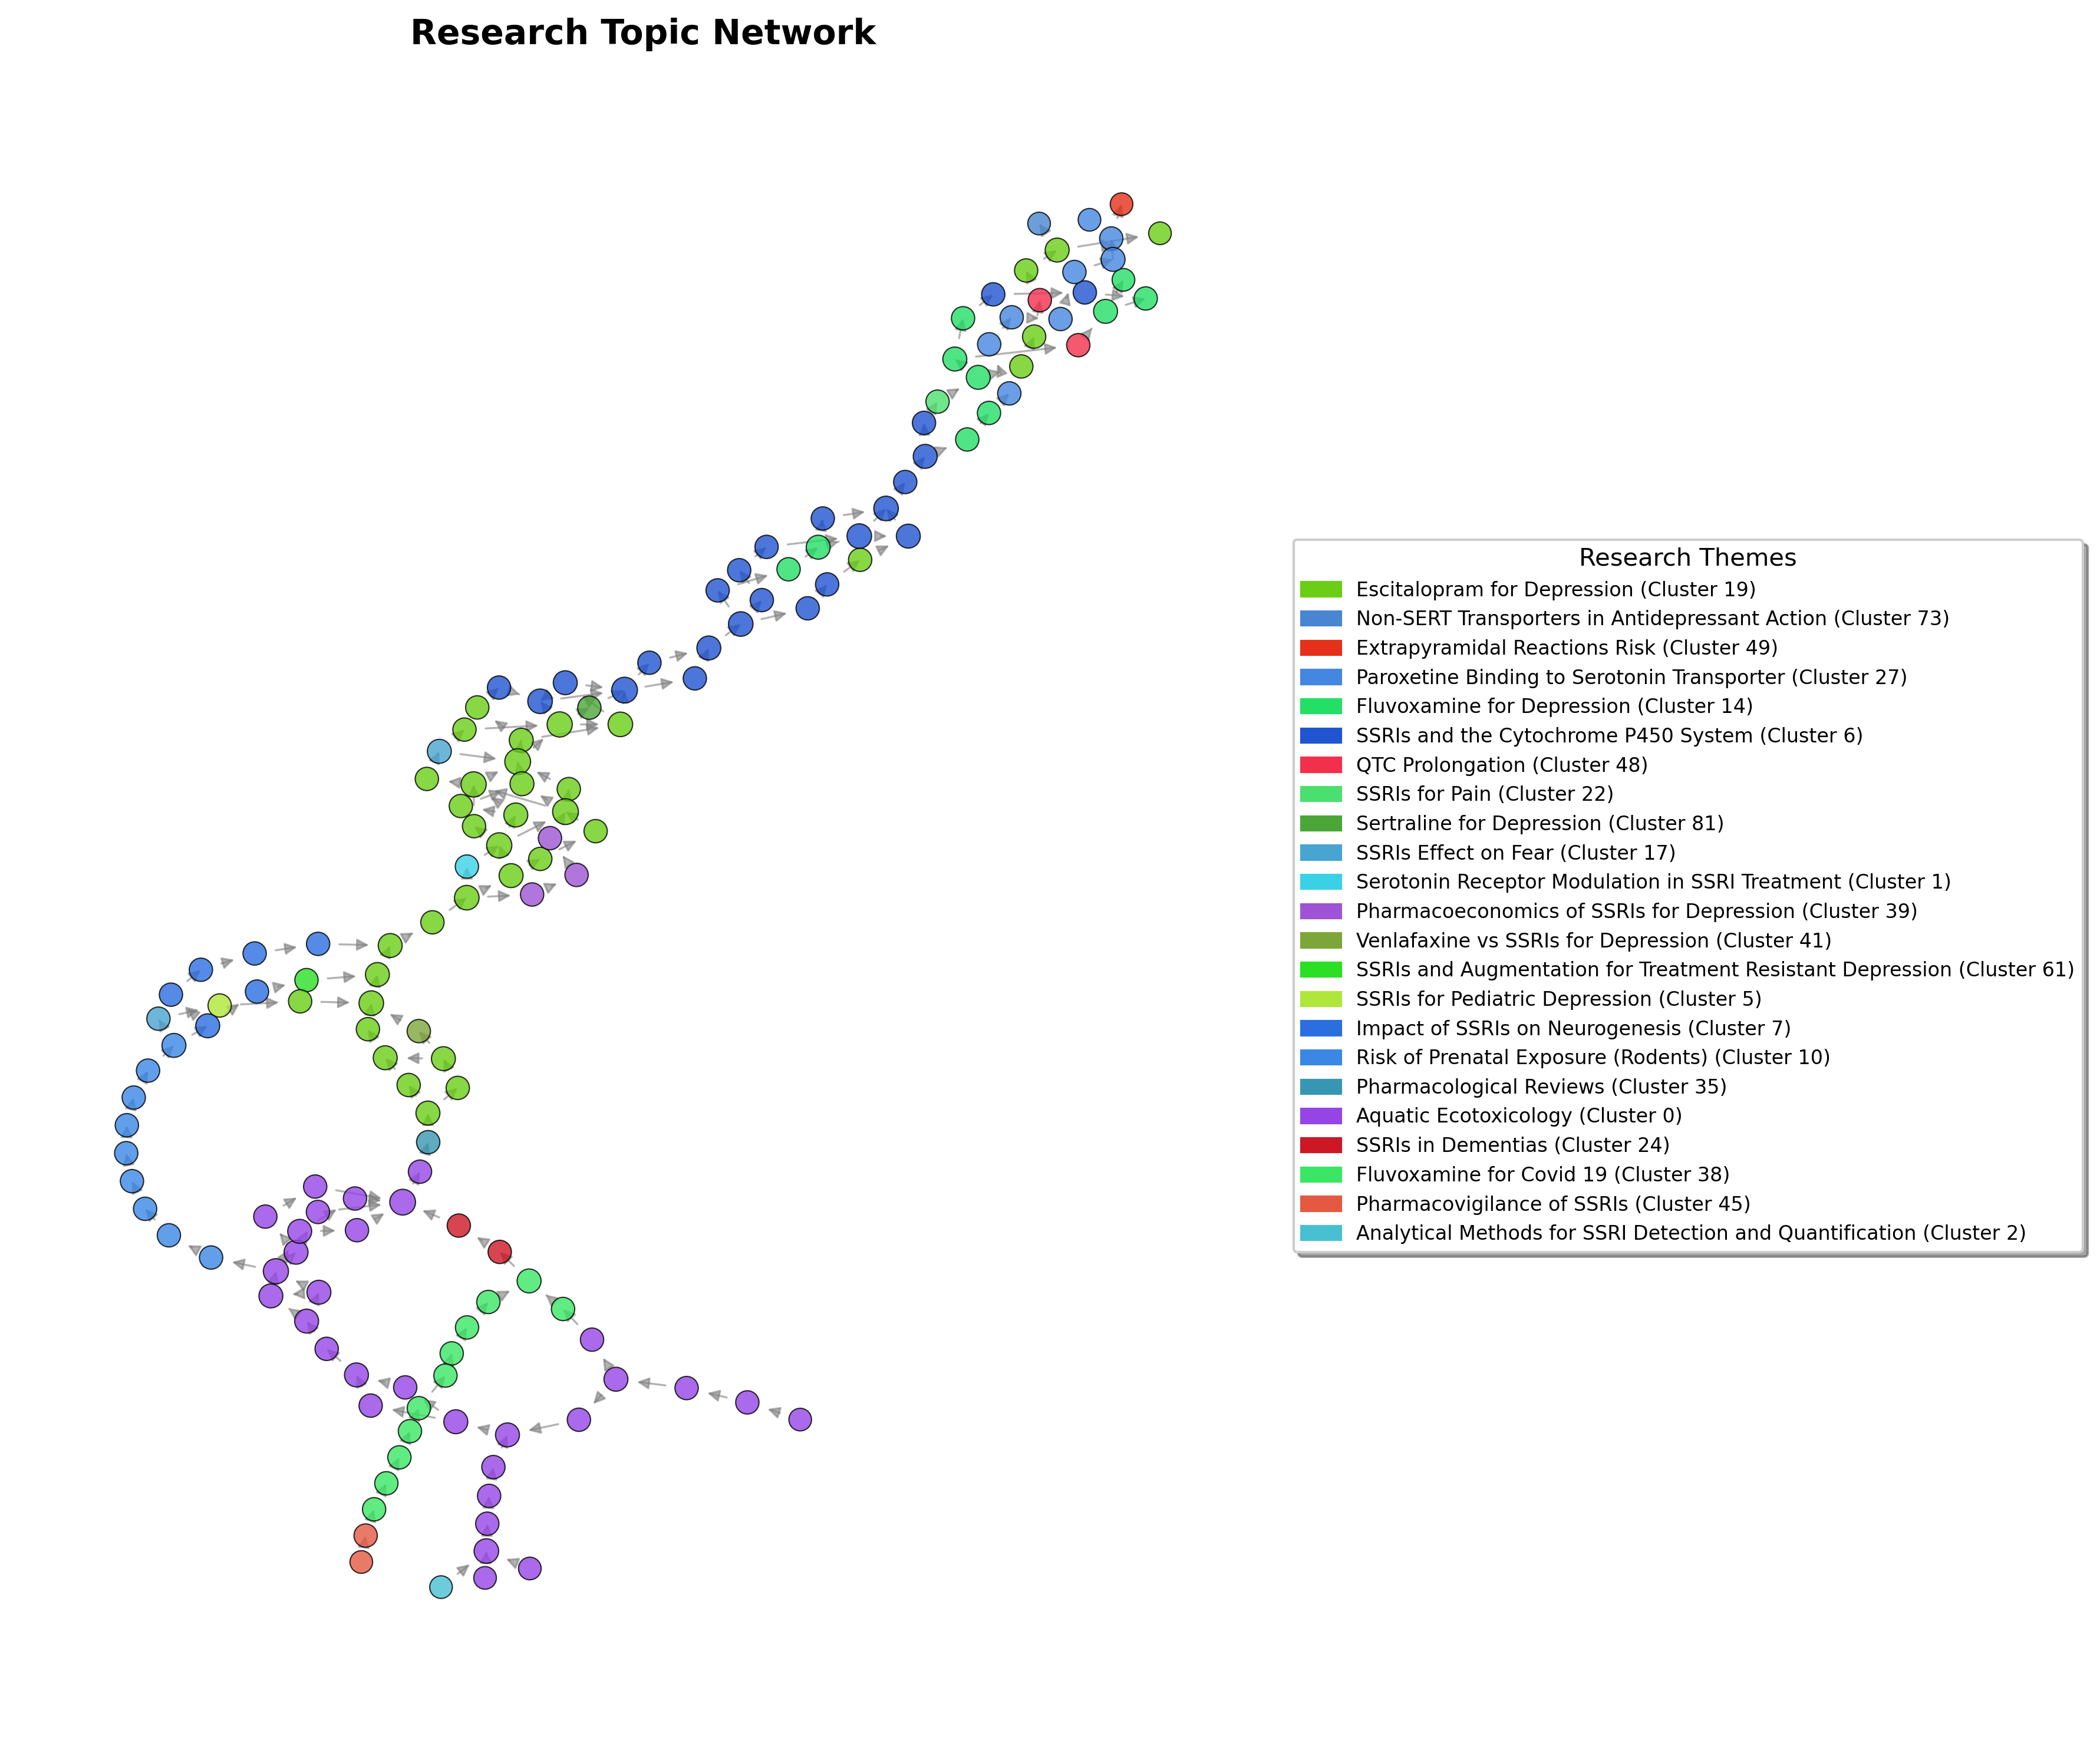

In [142]:
# For using the static plotter:
plotter = MainPathPlotterStatic(
    Gmp,
    cluster_col="cluster_alpha0.3_k10_res0.002",
    label_col="label",
    hover_cols=["title", "cited_by", "year", "first_author"],
    color_attr="color",
    cluster_label_attr="cluster_label",
)

# For a more spread out network with better node separation and integrated legend:
fig = plotter.plot_static_network(
    savingpath=output_dir + "/figures/main-paths/2025/static_network.png",
    layout_scale=5.0,  # Controls overall layout scale (lower = more dense)
    min_dist=0.15,  # Controls minimum distance between nodes (higher = more separation)
    node_size_base=80,  # Base size for nodes (adjust for visibility)
    node_size_factor=5,  # How much to scale nodes by degree
    figsize=(12, 10),  # Figure dimensions
    dpi=300,  # Output resolution
    title="Research Topic Network",
    with_labels=False,
    adjust_overlap=True,
    use_spring_layout=False,  # Try True for a more compact layout
    show_legend=True,  # Show the cluster legend
    legend_fontsize=8,  # Font size for legend text
    legend_title="Research Themes",  # Custom title for the legend
)

In [63]:
# New attempt

In [143]:
import colorcet as cc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex


class MainPathPlotterStatic:
    """
    A modified version of MainPathPlotterInteractive that creates static figures
    with better node separation and density control.
    """

    def __init__(
        self,
        G,
        cluster_col="cluster_0",
        label_col="label",
        hover_cols=["title", "cited_by", "year", "first_author"],
        color_attr="color",
        cluster_label_attr="cluster_label",
    ):
        """Initialize with the same parameters as the original class."""
        self.G = G
        self.cluster_col = cluster_col
        self.label_col = label_col
        self.color_attr = color_attr
        self.cluster_label_attr = cluster_label_attr

        # Add cluster information to hover if they exist in the graph
        additional_cols = []
        if cluster_label_attr in next(iter(G.nodes(data=True)))[1]:
            additional_cols.append(cluster_label_attr)
        if "doi" in next(iter(G.nodes(data=True)))[1]:
            additional_cols.append("doi")

        self.hover_cols = hover_cols + additional_cols

        # Don't add these twice if they're already included
        if label_col not in self.hover_cols:
            self.hover_cols.append(label_col)
        if cluster_col not in self.hover_cols:
            self.hover_cols.append(cluster_col)

        self.pos = None

    def adjust_overlap(self, min_dist=0.3, max_iterations=150):
        """
        Adjusts the positions to reduce overlap with increased minimum distance.

        Args:
            min_dist (float): Minimum desired distance between nodes.
            max_iterations (int): Maximum number of iterations to perform adjustments.

        Returns:
            dict: Adjusted positions.
        """
        for iteration in range(max_iterations):
            moved = False
            for node1 in self.pos:
                for node2 in self.pos:
                    if node1 != node2:
                        # Calculate the distance between two nodes
                        delta = np.array(self.pos[node1]) - np.array(self.pos[node2])
                        dist = np.sqrt(np.sum(delta**2))
                        # If the nodes are too close, push them apart
                        if dist < min_dist:
                            moved = True
                            # Increase the repulsion factor for more separation
                            repulsion_factor = 0.6  # Increased from 0.5
                            displacement = (
                                delta / dist * (min_dist - dist) * repulsion_factor
                            )
                            self.pos[node1] = self.pos[node1] + displacement
                            self.pos[node2] = self.pos[node2] - displacement
            # If no nodes were moved in this iteration, stop the adjustment
            if not moved:
                print(f"Adjustment finished after {iteration} iterations")
                break

        # Scale positions to fit well within the plot
        positions = np.array(list(self.pos.values()))
        x_min, y_min = positions.min(axis=0)
        x_max, y_max = positions.max(axis=0)

        # Normalize to fit within a reasonable range with a tighter scaling
        scale_factor = 0.9  # Reduced from 1.0 to make layout more dense
        for node in self.pos:
            self.pos[node] = (
                scale_factor
                * (self.pos[node] - np.array([x_min, y_min]))
                / np.array([x_max - x_min, y_max - y_min])
            )

        return self.pos

    def get_node_colors(self):
        """
        Get node colors from the color attribute if available, otherwise generate colors based on clusters.

        Returns:
            list: List of colors for each node.
        """
        # Check if color attribute exists from MainPathDataAssigner
        if self.color_attr in next(iter(self.G.nodes(data=True)))[1]:
            # Use the RGB values assigned by MainPathDataAssigner
            colors = []
            for _, data in self.G.nodes(data=True):
                rgb_values = data.get(self.color_attr)
                if isinstance(rgb_values, list) and len(rgb_values) == 3:
                    # Convert RGB values (0-1 scale) to hex color for matplotlib
                    r, g, b = rgb_values
                    color_hex = rgb2hex((r, g, b))
                    colors.append(color_hex)
                else:
                    # Default color if RGB values are not available
                    colors.append("#808080")  # Gray
            return colors
        else:
            # Generate colors based on clusters
            return self._generate_cluster_colors()

    def _generate_cluster_colors(self):
        """
        Generate colors based on cluster values.

        Returns:
            list: List of colors for each node.
        """
        clusters = [
            data.get(self.cluster_col, "0") for _, data in self.G.nodes(data=True)
        ]

        # Handle multi-cluster nodes (take the first cluster)
        processed_clusters = []
        for cluster in clusters:
            if isinstance(cluster, str) and ";" in cluster:
                processed_clusters.append(cluster.split(";")[0])
            else:
                processed_clusters.append(str(cluster))

        unique_clusters = sorted(set(processed_clusters))

        # Using colorcet to get a colormap with enough distinct colors
        color_list = cc.glasbey_dark[: len(unique_clusters)]

        # Creating a color dictionary mapping each cluster to a color
        color_dict = {
            cluster: color_list[i] for i, cluster in enumerate(unique_clusters)
        }

        # Generate colors for each node
        return [color_dict[cluster] for cluster in processed_clusters]

    def plot_static_network(
        self,
        savingpath=None,
        layout_scale=3.0,  # Reduced from 5.0 to make layout more dense
        min_dist=0.3,  # Increased from 0.15 for better separation
        node_size_base=80,  # Base node size for better visibility
        node_size_factor=5,  # Factor to multiply degree by
        figsize=(16, 12),  # Larger figure size
        dpi=150,  # Higher DPI for better quality
        label_fontsize=7,  # Smaller font for labels
        edge_width=0.8,  # Slightly thicker edges
        alpha=0.8,  # Node transparency
        title=None,
        with_labels=True,
        adjust_overlap=True,
        pos=None,
        use_spring_layout=False,  # Option to use spring layout instead of kamada_kawai
        show_legend=True,  # Whether to show the cluster legend
        legend_fontsize=8,  # Font size for legend
        legend_title="Clusters",  # Title for the legend
        place_labels_at_earliest_nodes=False,  # Place labels at earliest nodes
        use_timeline_layout=False,  # Use timeline-based layout
        arrow_size=10,  # Size of arrows on edges
        edge_alpha=0.6,  # Transparency of edges
    ):
        """
        Create a static network visualization using matplotlib.

        Args:
            savingpath (str, optional): Path to save the visualization.
            layout_scale (float): Scale parameter for the layout algorithm.
            min_dist (float): Minimum distance between nodes.
            node_size_base (int): Base size for nodes.
            node_size_factor (int): Factor to multiply node degree by for sizing.
            figsize (tuple): Figure dimensions (width, height).
            dpi (int): Dots per inch for the output figure.
            label_fontsize (int): Font size for node labels.
            edge_width (float): Width of edges.
            alpha (float): Transparency of nodes.
            title (str, optional): Plot title.
            with_labels (bool): Whether to show node labels.
            adjust_overlap (bool): Whether to adjust node positions to reduce overlap.
            pos (dict, optional): Pre-calculated node positions.
            use_spring_layout (bool): Use spring layout instead of kamada_kawai.
            show_legend (bool): Whether to show the cluster legend.
            legend_fontsize (int): Font size for the legend.
            legend_title (str): Title for the legend.
            place_labels_at_earliest_nodes (bool): Place cluster labels at the earliest nodes.
            use_timeline_layout (bool): Use timeline-based layout organized by year.
            arrow_size (int): Size of arrows on directed edges.
            edge_alpha (float): Transparency of edges.

        Returns:
            matplotlib.figure.Figure: The figure object.
        """
        # Set up the figure and axes with space for legend
        if show_legend and not place_labels_at_earliest_nodes:
            # Create figure with additional space on the right for legend
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
            plt.subplots_adjust(
                right=0.8
            )  # Adjust the right boundary to make room for legend
        else:
            fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        # Set node positions - prioritize timeline layout if requested
        if use_timeline_layout:
            self.pos = self._create_timeline_layout()
        elif not pos:
            if use_spring_layout:
                # Spring layout can produce more compact layouts
                self.pos = nx.spring_layout(
                    self.G,
                    k=layout_scale / np.sqrt(len(self.G)),  # Optimal distance
                    iterations=150,  # More iterations for better convergence
                    seed=42,  # For reproducibility
                )
            else:
                # Default to kamada_kawai for better distributed layouts
                self.pos = nx.kamada_kawai_layout(
                    self.G,
                    weight=None,
                    scale=layout_scale,
                    center=None,
                    dim=2,
                )
        else:
            self.pos = pos

        # Adjust node positions to reduce overlap if requested
        if adjust_overlap:
            self.pos = self.adjust_overlap(min_dist, 150)

        # Get node colors
        node_colors = self.get_node_colors()

        # Calculate node sizes based on node degree
        degrees = dict(self.G.degree())
        node_sizes = [
            node_size_base + (degrees[node] * node_size_factor)
            for node in self.G.nodes()
        ]

        # Get node labels if needed
        if with_labels:
            node_labels = {
                node: data.get(self.label_col, "")
                for node, data in self.G.nodes(data=True)
            }
        else:
            node_labels = {}

        # Draw the network
        # Draw edges first so they appear under nodes
        if isinstance(self.G, nx.DiGraph):
            # For directed graphs, draw with arrows
            nx.draw_networkx_edges(
                self.G,
                self.pos,
                ax=ax,
                width=edge_width,
                alpha=edge_alpha,
                edge_color="gray",
                arrowsize=arrow_size,
                connectionstyle="arc3,rad=0.1",  # Curved edges for better visibility
            )
        else:
            # For undirected graphs
            nx.draw_networkx_edges(
                self.G,
                self.pos,
                ax=ax,
                width=edge_width,
                alpha=edge_alpha,
                edge_color="gray",
            )

        # Draw nodes
        nx.draw_networkx_nodes(
            self.G,
            self.pos,
            ax=ax,
            node_size=node_sizes,
            node_color=node_colors,
            alpha=alpha,
            edgecolors="black",
            linewidths=0.5,
        )

        # Draw labels if requested
        if with_labels:
            nx.draw_networkx_labels(
                self.G,
                self.pos,
                ax=ax,
                labels=node_labels,
                font_size=label_fontsize,
                font_weight="normal",
                font_color="black",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.5),
            )

        # Add title if provided
        if title:
            ax.set_title(title, fontsize=14, fontweight="bold")

        # Remove axes
        ax.axis("off")

        # Add legend if requested
        if (
            show_legend
            and self.cluster_label_attr in next(iter(self.G.nodes(data=True)))[1]
        ):
            self._add_legend_to_plot(
                ax, legend_fontsize, legend_title, place_labels_at_earliest_nodes
            )

        # If using timeline layout, add year labels on the x-axis
        if use_timeline_layout:
            self._add_timeline_axis(ax)

        # Adjust layout
        plt.tight_layout()

        # Save the figure if savingpath is provided
        if savingpath:
            plt.savefig(savingpath, dpi=dpi, bbox_inches="tight")
            print(f"Figure saved to {savingpath}")

        # Show the figure
        plt.show()

        # Return the figure object
        return fig

    def _create_timeline_layout(self):
        """
        Create a timeline-based layout where x-position corresponds to year
        and y-position is determined by cluster membership.

        Returns:
            dict: Node positions dictionary
        """
        positions = {}

        # Get years for all nodes
        years = {}
        clusters = {}
        default_year = 0

        # Collect year and cluster information
        for node, data in self.G.nodes(data=True):
            # Get year
            year = data.get("year", default_year)

            # Handle multiple years or string years
            if isinstance(year, str):
                try:
                    years_list = [
                        int(y.strip()) for y in year.split(";") if y.strip().isdigit()
                    ]
                    if years_list:
                        year = min(years_list)
                    else:
                        year = default_year
                except ValueError:
                    year = default_year

            years[node] = year

            # Get cluster
            cluster_id = data.get(self.cluster_col, "0")
            if isinstance(cluster_id, str) and ";" in cluster_id:
                cluster_id = cluster_id.split(";")[0]

            clusters[node] = cluster_id

        # Get unique clusters and years
        unique_clusters = sorted(set(clusters.values()))
        min_year = min(years.values()) if years else default_year
        max_year = max(years.values()) if years else default_year
        year_range = max(1, max_year - min_year)

        # Create a cluster to y-position mapping
        cluster_positions = {
            cluster: idx / max(1, len(unique_clusters) - 1)
            for idx, cluster in enumerate(unique_clusters)
        }

        # Calculate node positions
        for node in self.G.nodes():
            # Normalize X position by year
            x_pos = (years[node] - min_year) / year_range

            # Y position by cluster with small random offset for same-cluster nodes
            cluster = clusters[node]
            y_pos = cluster_positions[cluster]

            # Add small random vertical offset to avoid exact overlaps
            y_offset = 0.05 * (np.random.random() - 0.5)

            positions[node] = (x_pos, y_pos + y_offset)

        return positions

    def _add_timeline_axis(self, ax):
        """
        Add year labels to the x-axis for timeline visualization.

        Args:
            ax (matplotlib.axes.Axes): The axes to add timeline labels to.
        """
        # Collect all years
        years = []
        for _, data in self.G.nodes(data=True):
            if "year" in data:
                year = data["year"]
                if isinstance(year, str):
                    try:
                        years_list = [
                            int(y.strip())
                            for y in year.split(";")
                            if y.strip().isdigit()
                        ]
                        years.extend(years_list)
                    except ValueError:
                        pass
                else:
                    years.append(year)

        if not years:
            return

        # Get min and max years
        min_year = min(years)
        max_year = max(years)
        year_range = max_year - min_year

        # Determine appropriate year step based on range
        if year_range <= 10:
            year_step = 1
        elif year_range <= 50:
            year_step = 5
        else:
            year_step = 10

        # Create year labels
        timeline_years = list(range(min_year, max_year + 1, year_step))

        # Calculate normalized positions for the years
        x_positions = [
            (year - min_year) / max(1, year_range) for year in timeline_years
        ]

        # Add a subtle axis line at the bottom
        ax.axhline(y=-0.05, color="gray", alpha=0.3, linestyle="-", linewidth=0.5)

        # Add year labels
        for x, year in zip(x_positions, timeline_years):
            ax.text(
                x,
                -0.08,
                str(year),
                horizontalalignment="center",
                verticalalignment="top",
                fontsize=8,
                alpha=0.8,
            )

            # Add small tick mark
            ax.plot([x, x], [-0.05, -0.06], color="gray", alpha=0.3, linewidth=0.5)

    def _add_legend_to_plot(
        self, ax, fontsize=8, title="Clusters", place_at_earliest_nodes=False
    ):
        """
        Add a legend to the plot.

        Args:
            ax (matplotlib.axes.Axes): Axes to add legend to.
            fontsize (int): Font size for legend.
            title (str): Legend title.
            place_at_earliest_nodes (bool): If True, place labels at earliest node of each cluster.

        Returns:
            matplotlib.legend.Legend: The legend object.
        """
        # Get cluster labels and colors
        cluster_data = {}

        for _, data in self.G.nodes(data=True):
            cluster_id = data.get(self.cluster_col, "0")
            if isinstance(cluster_id, str) and ";" in cluster_id:
                cluster_id = cluster_id.split(";")[0]

            cluster_label = data.get(self.cluster_label_attr, "Unknown")
            if isinstance(cluster_label, str) and ";" in cluster_label:
                cluster_label = cluster_label.split(";")[0]

            # Get color from the node
            if self.color_attr in data:
                rgb_values = data.get(self.color_attr)
                if isinstance(rgb_values, list) and len(rgb_values) == 3:
                    r, g, b = rgb_values
                    color = rgb2hex((r, g, b))
                    cluster_data[cluster_id] = (cluster_label, color)

        if not place_at_earliest_nodes:
            # Create traditional legend with patches
            import matplotlib.patches as mpatches

            legend_patches = []

            for cluster_id, (label, color) in cluster_data.items():
                patch = mpatches.Patch(
                    color=color, label=f"{label} (Cluster {cluster_id})"
                )
                legend_patches.append(patch)

            # Add legend to the axes
            legend = ax.legend(
                handles=legend_patches,
                loc="center left",
                fontsize=fontsize,
                title=title,
                title_fontsize=fontsize + 2,
                bbox_to_anchor=(1.02, 0.5),  # Position the legend outside the plot
                borderaxespad=0,
                fancybox=True,
                shadow=True,
            )

            return legend

        else:
            # Find earliest node in each cluster
            earliest_nodes = self._find_earliest_nodes_by_cluster()
            legend_handles = []

            # Add annotations at the earliest node of each cluster
            for cluster_id, (label, color) in cluster_data.items():
                if cluster_id in earliest_nodes:
                    node = earliest_nodes[cluster_id]
                    pos = self.pos[node]

                    # Create annotation with colored box
                    box_props = dict(
                        boxstyle="round,pad=0.3",
                        facecolor=color,
                        alpha=0.8,
                        edgecolor="black",
                        linewidth=1,
                    )

                    # Add annotation slightly above and to the right of the node
                    annotation = ax.annotate(
                        f"{label}",
                        xy=pos,
                        xytext=(pos[0] + 0.02, pos[1] + 0.02),
                        fontsize=fontsize,
                        bbox=box_props,
                        horizontalalignment="left",
                        verticalalignment="bottom",
                    )

                    legend_handles.append(annotation)

            return legend_handles

    def _find_earliest_nodes_by_cluster(self):
        """
        Find the earliest (oldest) node for each cluster based on 'year' attribute.

        Returns:
            dict: Dictionary mapping cluster_id to earliest node in that cluster.
        """
        earliest_nodes = {}
        earliest_years = {}

        # Default year if not found
        default_year = 9999

        # First pass: find earliest year for each cluster
        for node, data in self.G.nodes(data=True):
            # Get cluster ID
            cluster_id = data.get(self.cluster_col, "0")
            if isinstance(cluster_id, str) and ";" in cluster_id:
                cluster_id = cluster_id.split(";")[0]

            # Get year (or other chronological attribute)
            year = data.get("year", default_year)

            # Handle multiple years or string years
            if isinstance(year, str):
                try:
                    years = [
                        int(y.strip()) for y in year.split(";") if y.strip().isdigit()
                    ]
                    if years:
                        year = min(years)
                    else:
                        year = default_year
                except ValueError:
                    year = default_year

            # If no year found, try to use the node's position on x-axis as a proxy
            if year == default_year and self.pos is not None:
                # Assume x-position corresponds roughly to chronological order
                year = self.pos[node][0]

            # Update earliest year for this cluster
            if cluster_id not in earliest_years or year < earliest_years[cluster_id]:
                earliest_years[cluster_id] = year
                earliest_nodes[cluster_id] = node

        return earliest_nodes

    # Keeping the old method for backward compatibility but deprecated
    def create_cluster_legend(
        self, figure=None, loc="upper right", fontsize=8, title="Clusters"
    ):
        """
        Create a legend showing cluster colors and labels (deprecated).
        Use plot_static_network with show_legend=True instead.

        Args:
            figure (matplotlib.figure.Figure, optional): Figure to add legend to.
            loc (str): Legend location.
            fontsize (int): Font size for legend.
            title (str): Legend title.

        Returns:
            matplotlib.legend.Legend: The legend object.
        """
        print(
            "Warning: This method is deprecated. Use plot_static_network with show_legend=True instead."
        )

        # Check if cluster label attribute exists
        if self.cluster_label_attr not in next(iter(self.G.nodes(data=True)))[1]:
            return None

        # Get current axes from figure
        if figure is None:
            figure = plt.gcf()

        ax = figure.gca()

        return self._add_legend_to_plot(ax, fontsize, title)

In [144]:
# For using the static plotter with cluster labels at earliest nodes:
plotter = MainPathPlotterStatic(
    Gmp,
    cluster_col="cluster_alpha0.3_k10_res0.002",
    label_col="label",
    hover_cols=["title", "cited_by", "year", "first_author"],
    color_attr="color",
    cluster_label_attr="cluster_label",
)

Figure saved to /Users/jlq293/Projects/Study-1-Bibliometrics/output/figures/main-paths/2025/static_network_with_earliest_labels.png


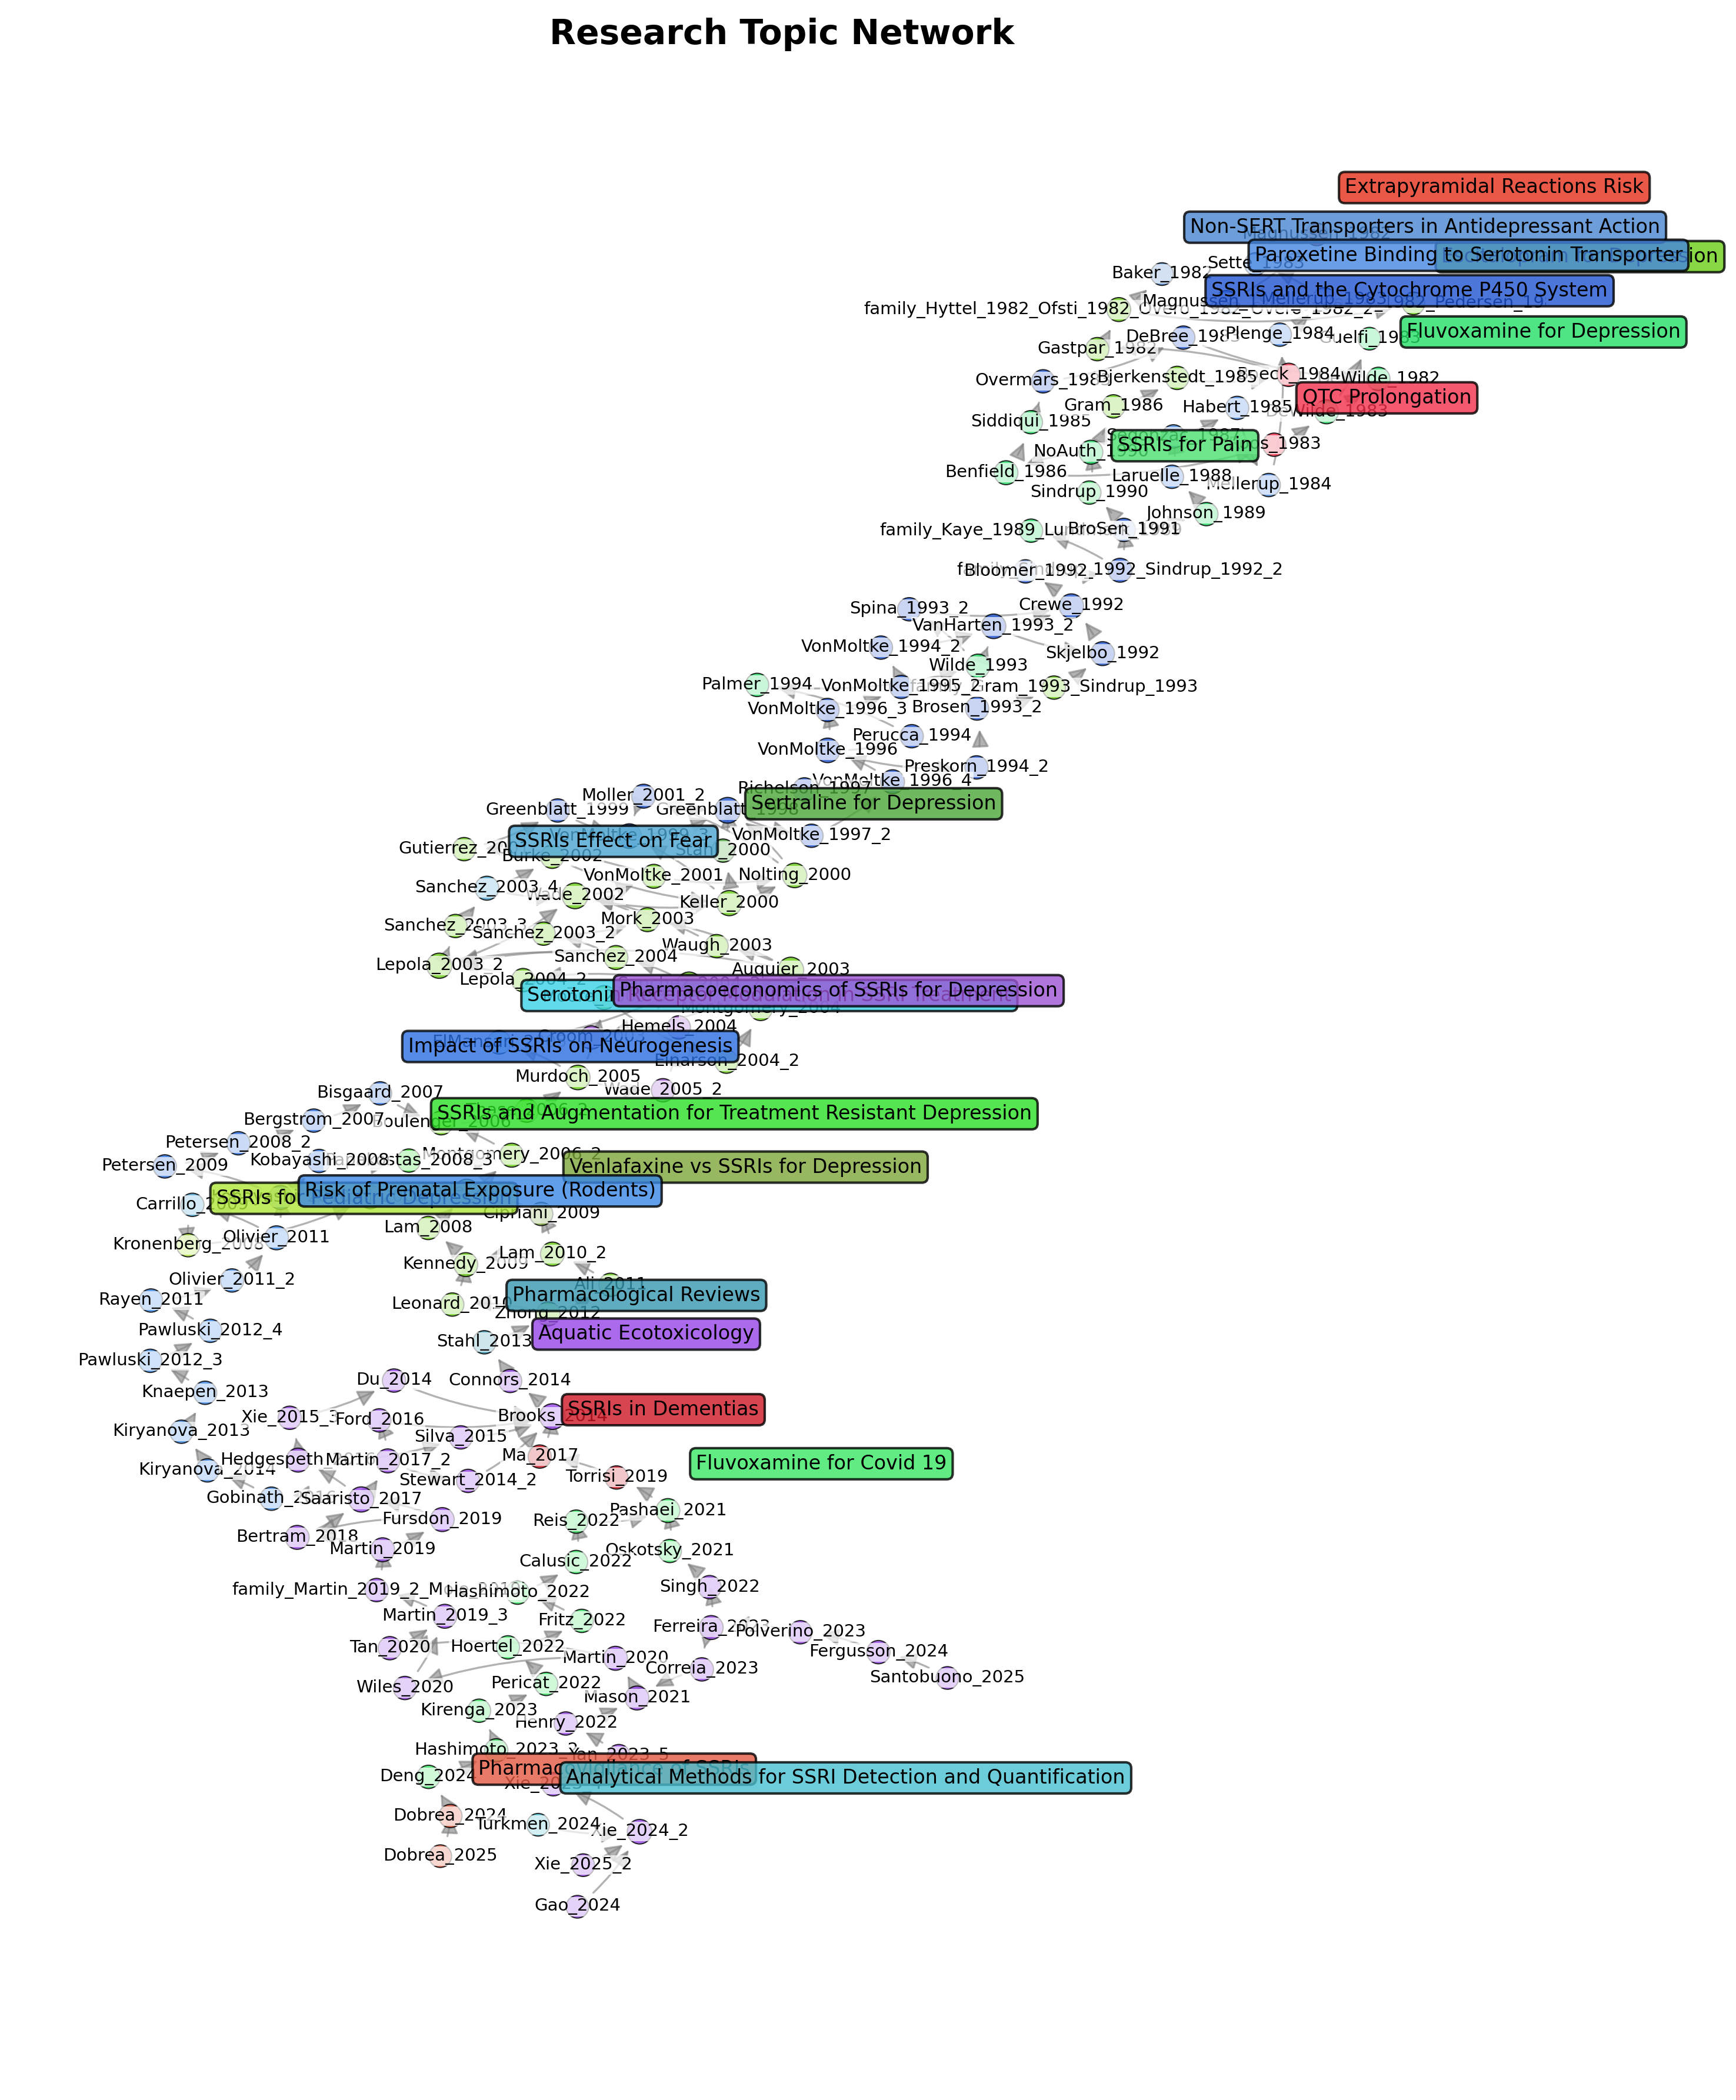

In [155]:
# Option 1: Force-directed layout with cluster labels at earliest nodes
fig = plotter.plot_static_network(
    savingpath=output_dir
    + "/figures/main-paths/2025/static_network_with_earliest_labels.png",
    layout_scale=2.0,  # Controls overall layout scale
    min_dist=0.1,  # Controls minimum distance between nodes
    node_size_base=80,  # Base size for nodes
    figsize=(10, 12),  # Figure dimensions
    dpi=300,  # Dots per inch for the output figure
    title="Research Topic Network",
    show_legend=True,  # Show legends
    place_labels_at_earliest_nodes=True,  # Place cluster labels at earliest nodes
    arrow_size=15,  # Size of arrows for directed edges
)

Figure saved to timeline_main_path.png


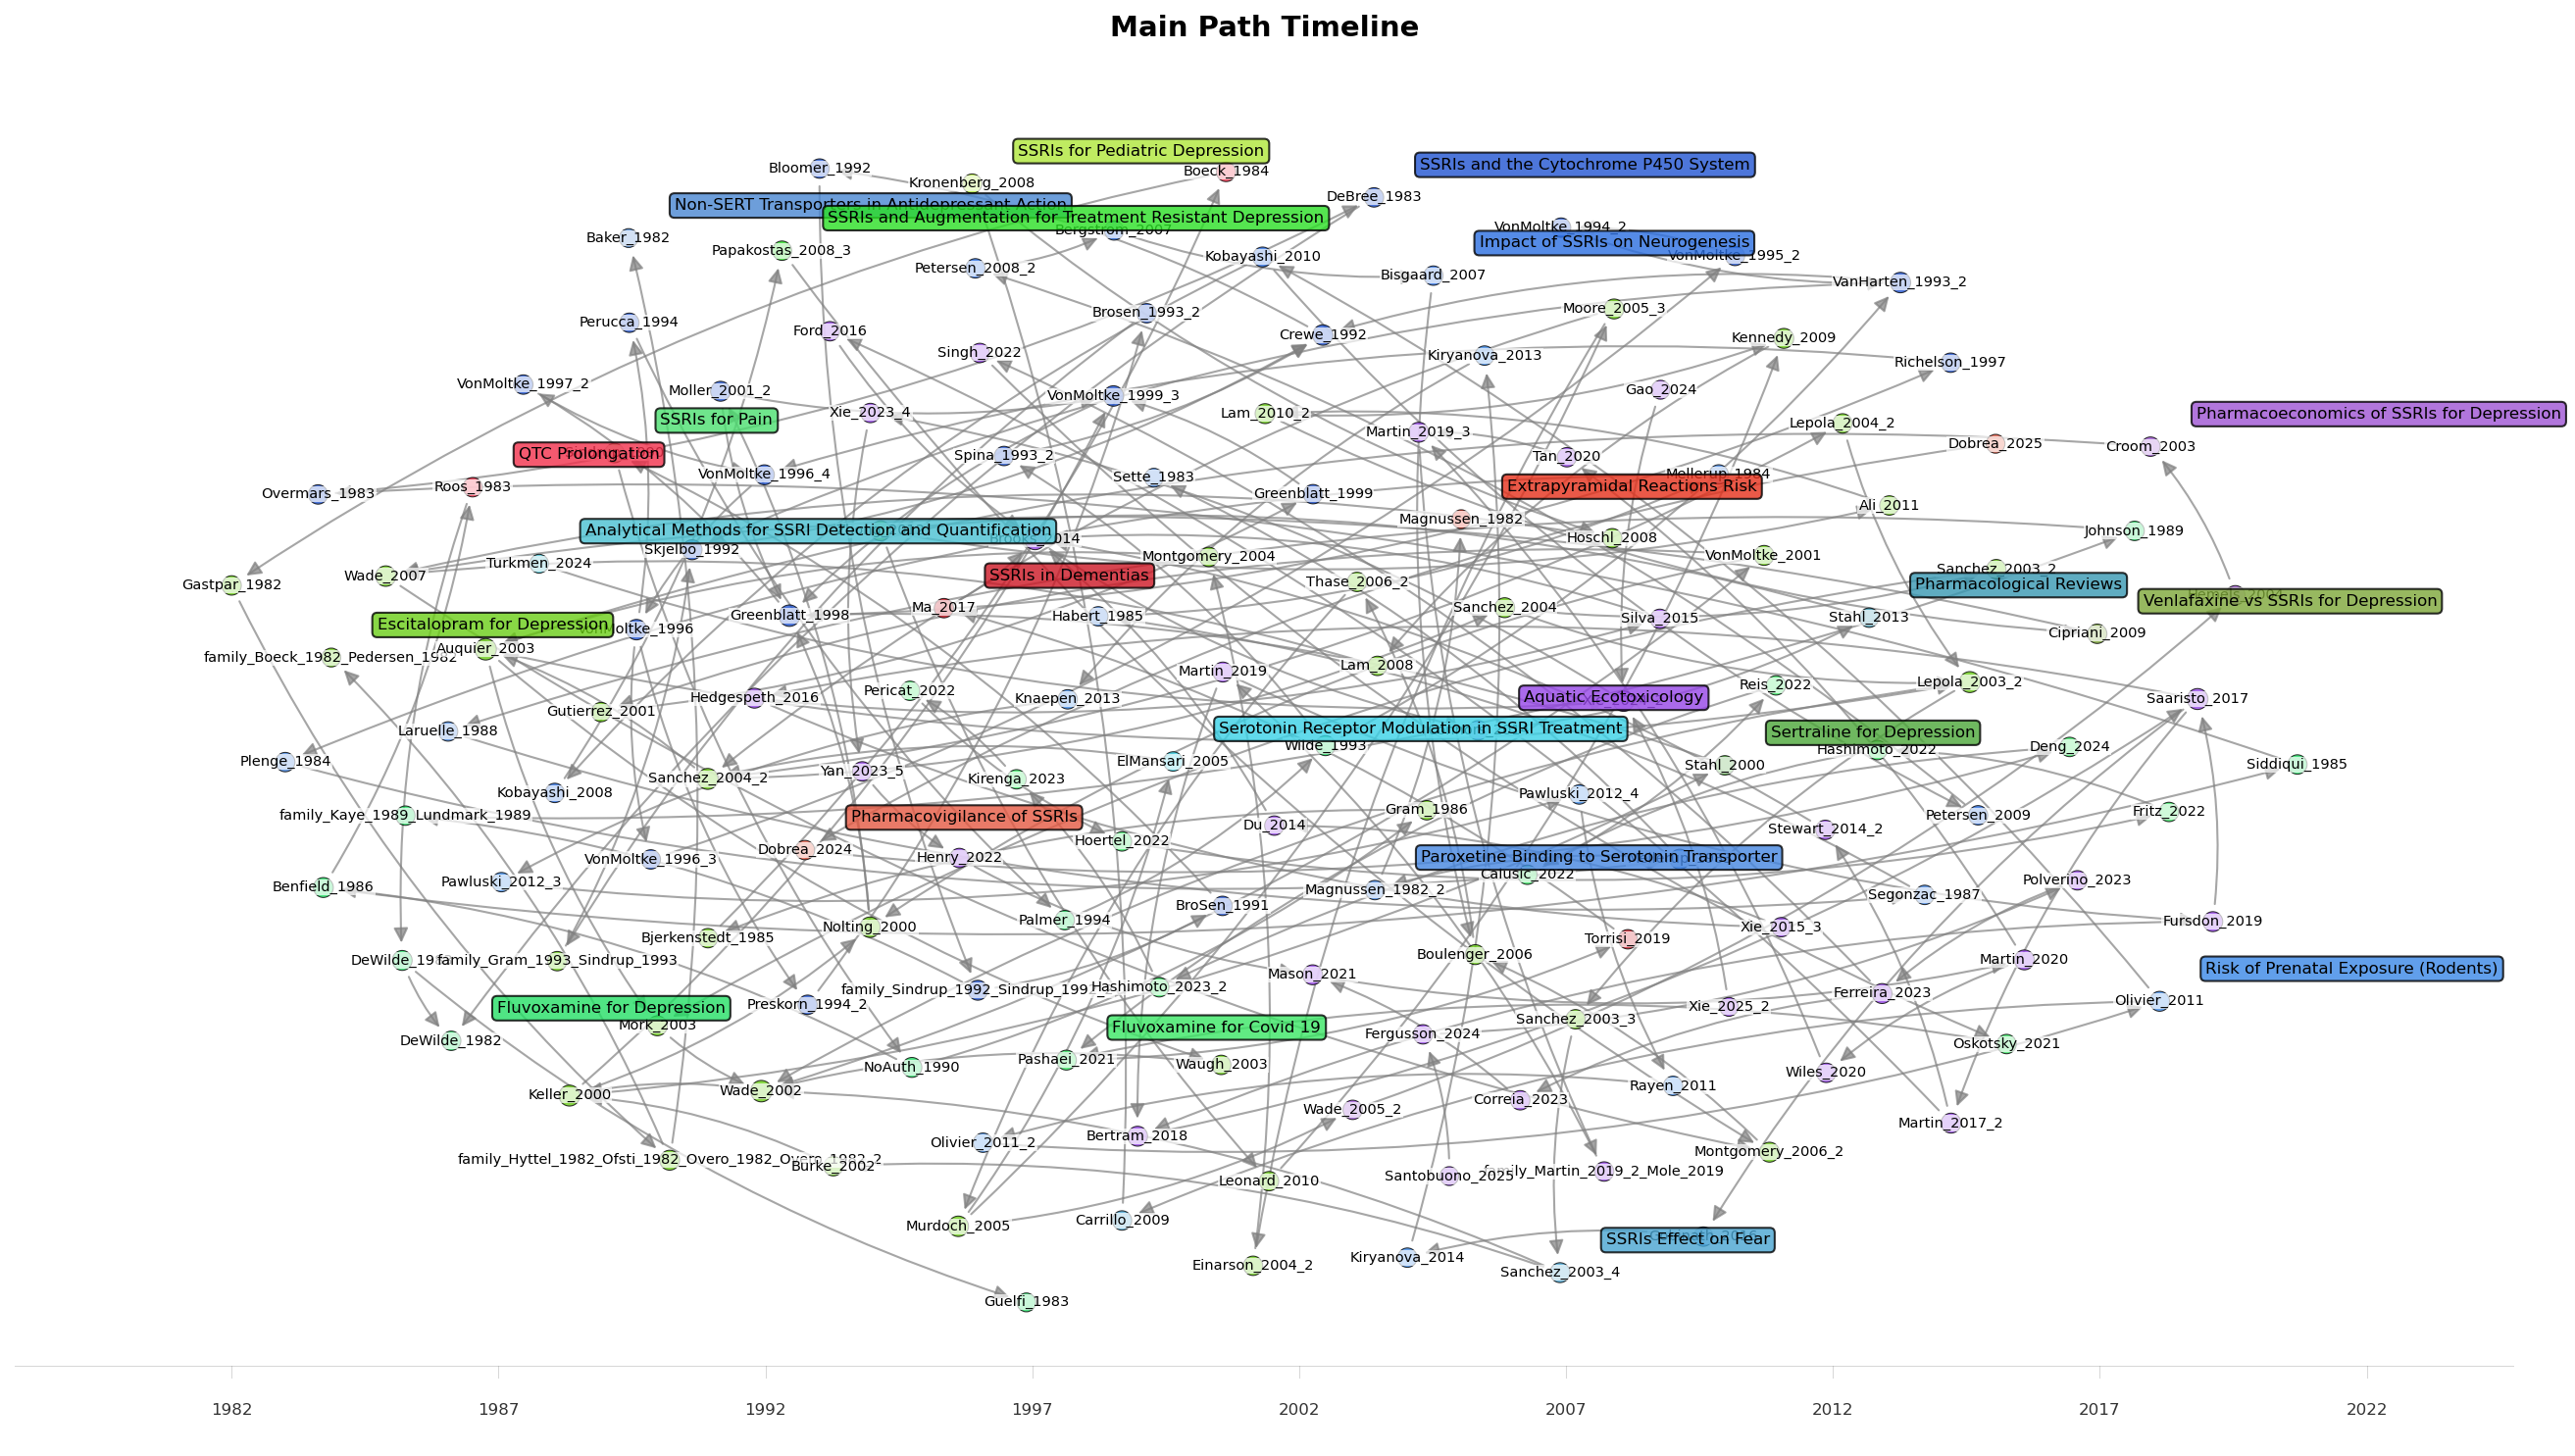

In [69]:
# Option 2: Timeline-based layout (recommended for main path analysis)
fig2 = plotter.plot_static_network(
    savingpath="timeline_main_path.png",
    figsize=(18, 10),  # Wider figure for timeline
    title="Main Path Timeline",
    use_timeline_layout=True,  # Use chronological layout
    show_legend=True,
    place_labels_at_earliest_nodes=True,
    edge_width=1.0,  # Slightly thicker edges
    edge_alpha=0.7,  # More visible edges
    arrow_size=15,  # Larger arrows
)

In [ ]:
bbaaa